In [1]:
import os

import pandas as pd
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


C:\Users\xiaoyicong\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load Data

In [2]:
data_folder = 'data'

In [3]:
train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [6]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
# cast date column

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# EDA

### Null-values

Some of the target values in train set is missing

In [10]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [11]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [17]:
train[train['num_sold'].isnull()].groupby(['country', 'store', 'product']).count()

id  date  num_sold
country store                product                                 
Canada  Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler               1     1         0
        Premium Sticker Mart Holographic Goose    380   380         0
        Stickers for Less    Holographic Goose   1308  1308         0
Kenya   Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler              63    63         0
                             Kerneler Dark Mode     1     1         0
        Premium Sticker Mart Holographic Goose    646   646         0
        Stickers for Less    Holographic Goose   1358  1358         0

### Time Series Distribution

In [36]:
def plot_grouped_time_series(df, grouped_by = ['store', 'product'], x_axis = 'date', y_axis = 'num_sold', title = 'TITLE'):
    '''
    Group by the columns in groupd_by
    plot a series of y_axis vs. x_axis for each group
    '''
    fig, ax = plt.subplots()

    for group_columns, group in df.groupby(grouped_by):
        group.plot(x=x_axis, y=y_axis, ax=ax, label=group_columns)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend(title=f'Grouped by: {grouped_by}', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.tight_layout()
    plt.show()

def plot_single_serie(df, date_col = 'date', quant_col = 'num_sold'):
    # Plotting the time series
    plt.figure(figsize=(10, 6))
    if df.index.name == date_col:
        plt.plot(df.index, df[quant_col], marker='o', color='b', linestyle='-')
    else:
        plt.plot(df[date_col], df[quant_col], marker='o', color='b', linestyle='-')
    plt.title(f'Time Series of {quant_col}')
    plt.xlabel(date_col)
    plt.ylabel(quant_col)
    plt.grid(True)
    plt.show()

##### Group by country and store

1. The scale of `num_sold` vary across countries and stores (e.g. 200-1500 level in Canada v.s. 5-100 level in Kenya)
2. The relative distribution among different products is visually-similar across different `(country, store)` groups

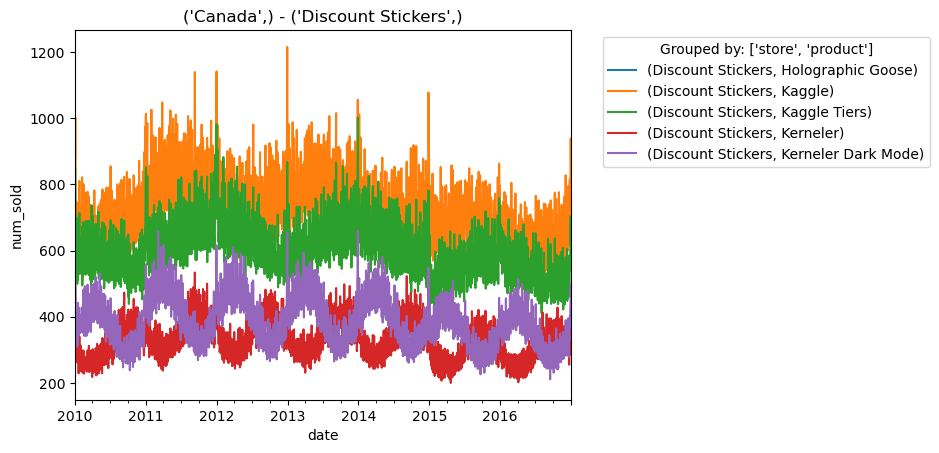

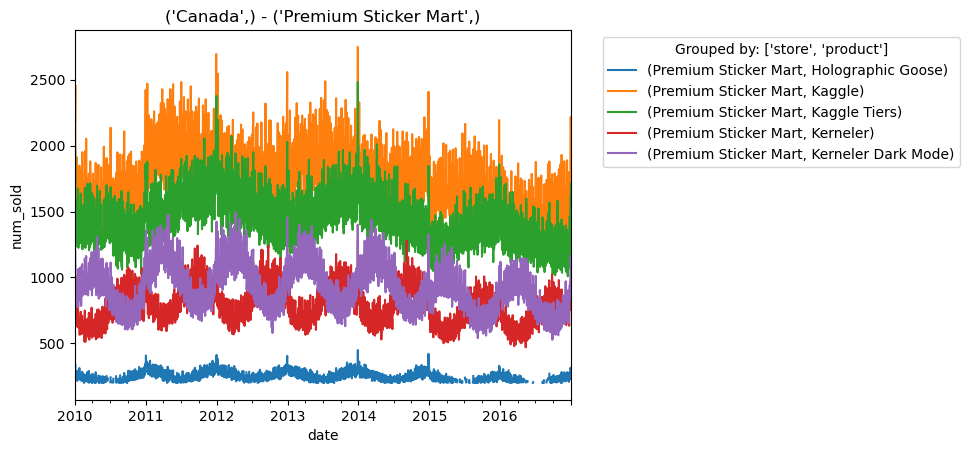

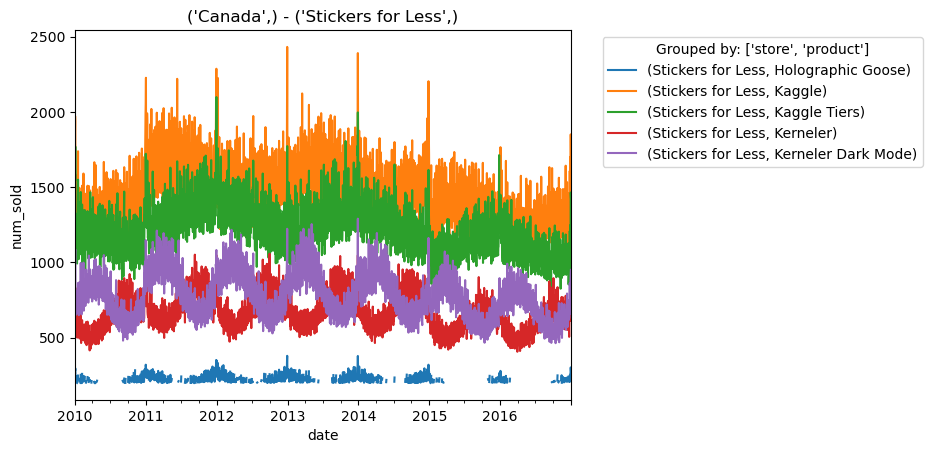

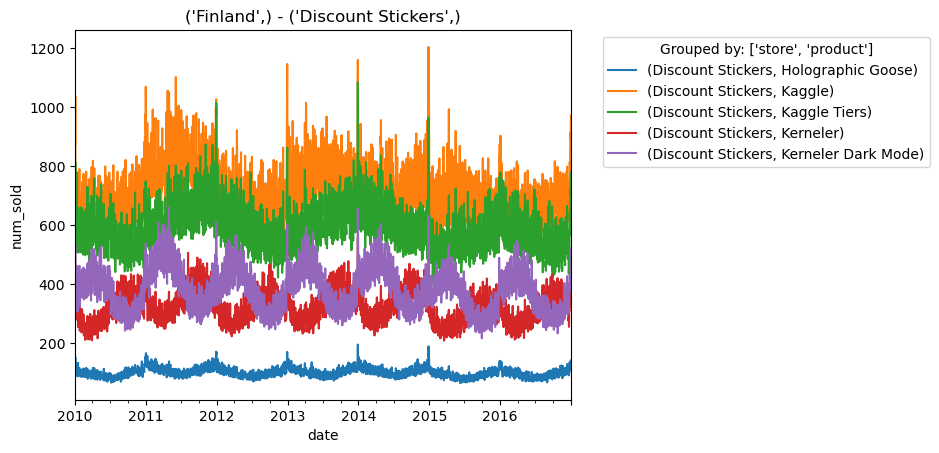

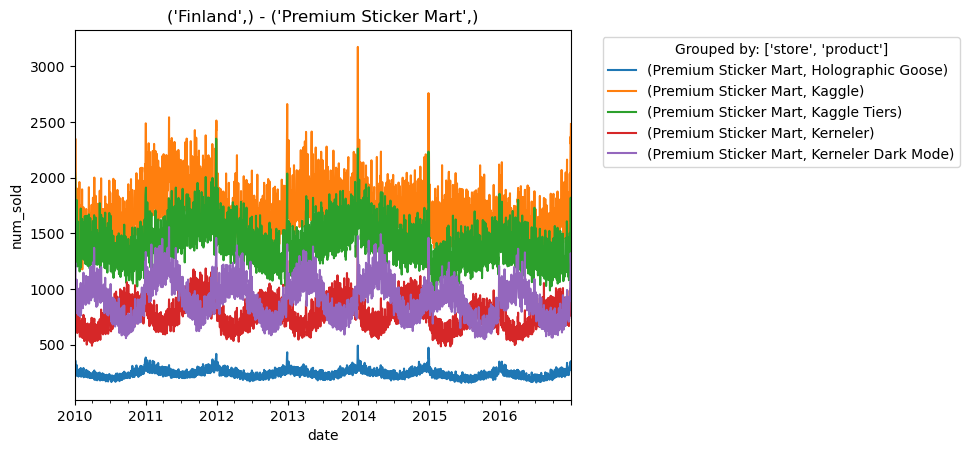

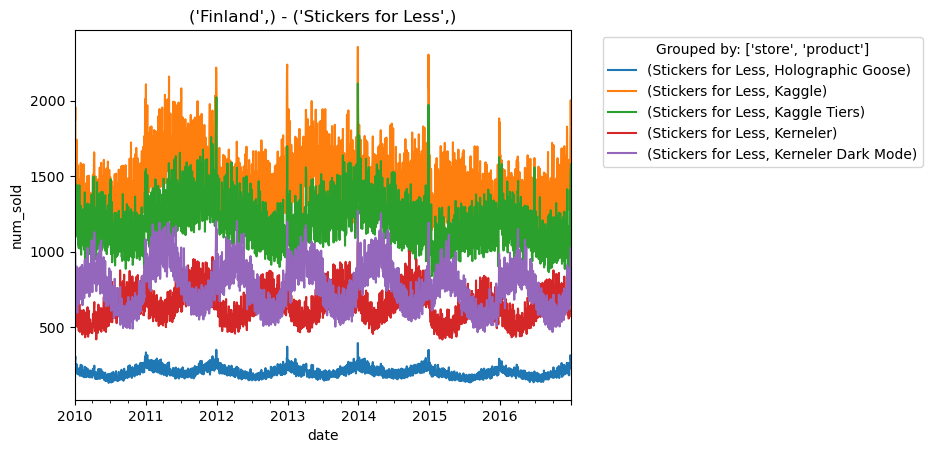

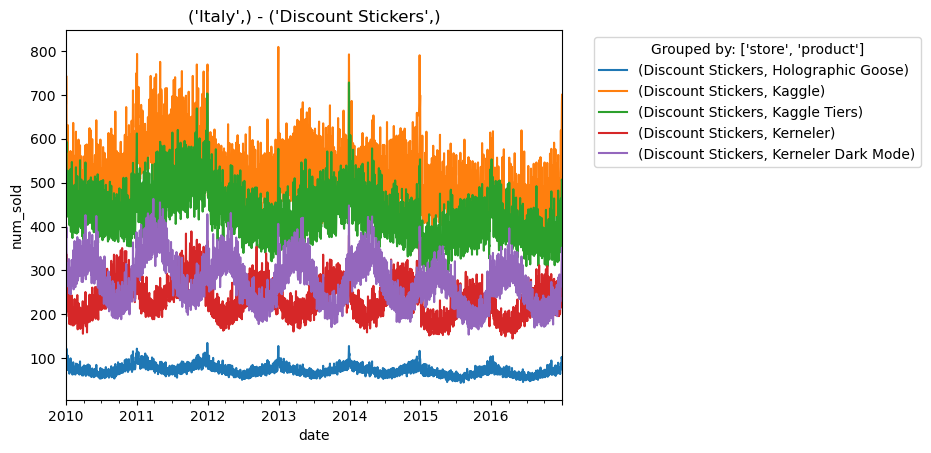

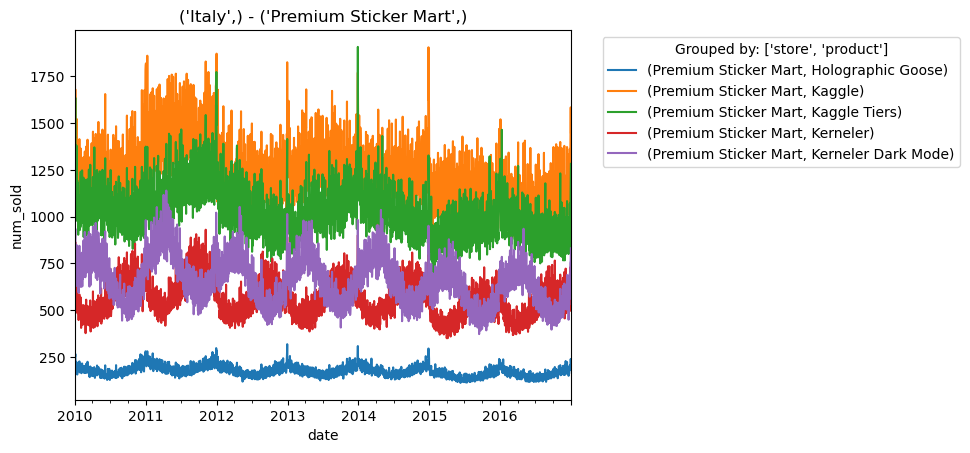

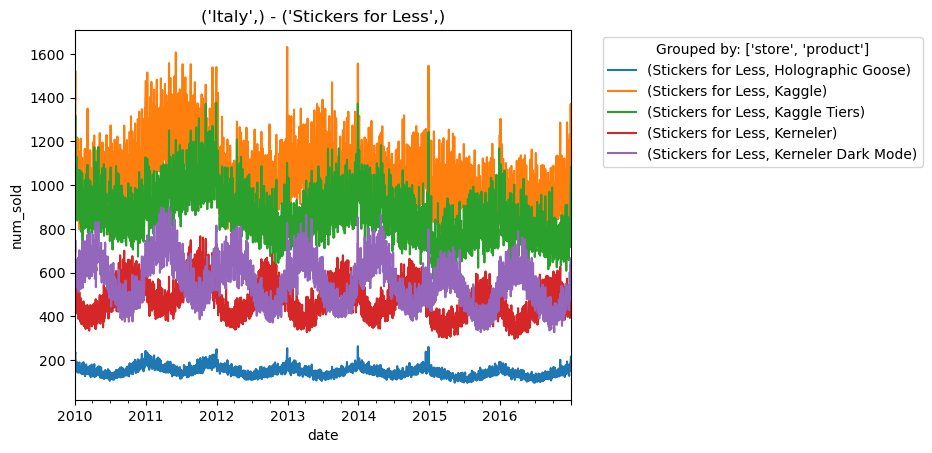

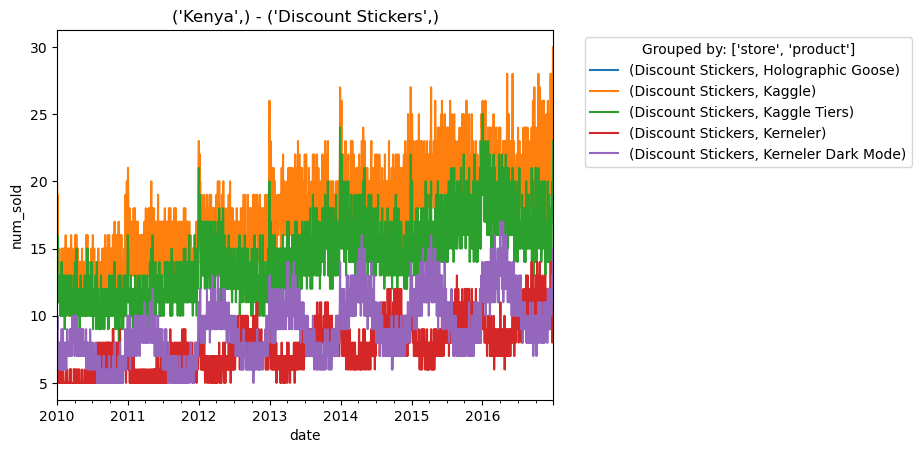

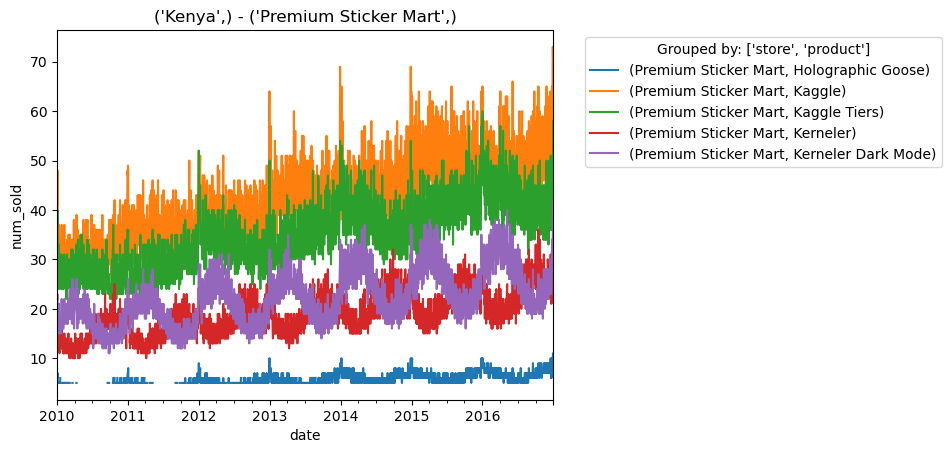

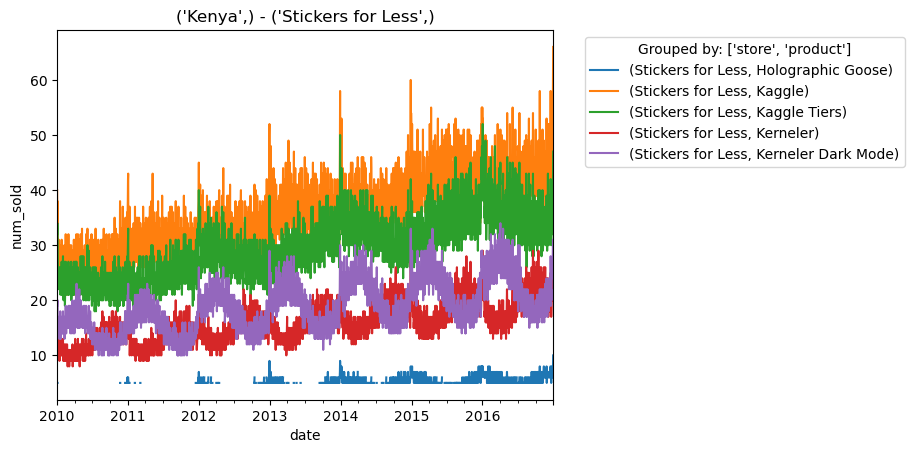

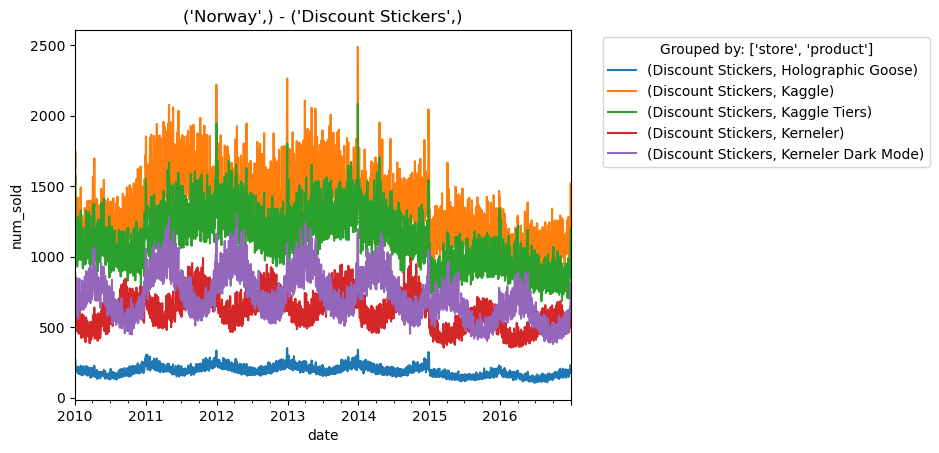

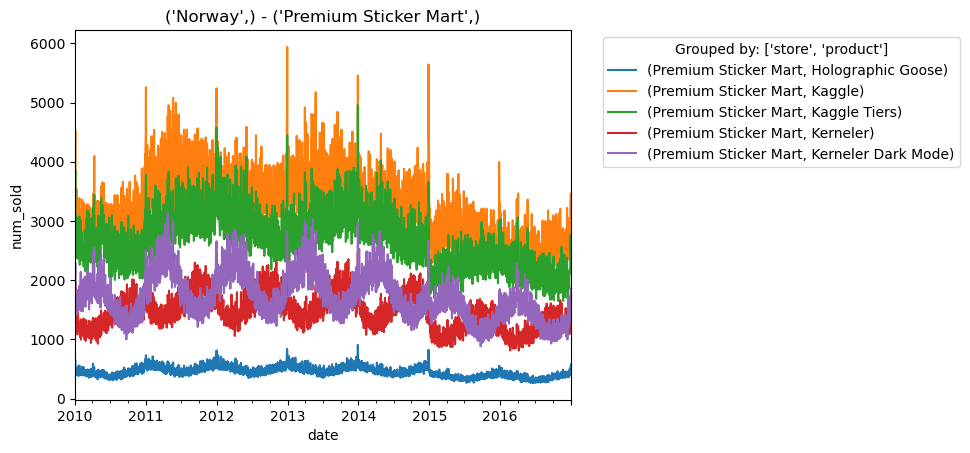

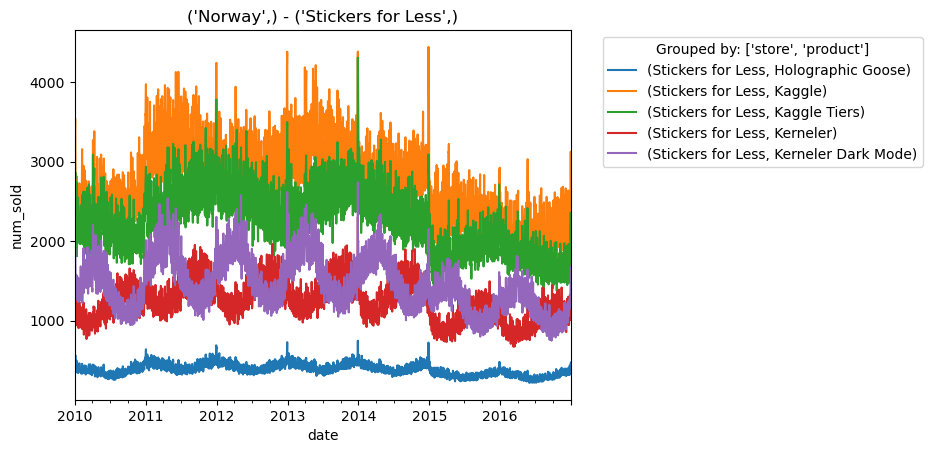

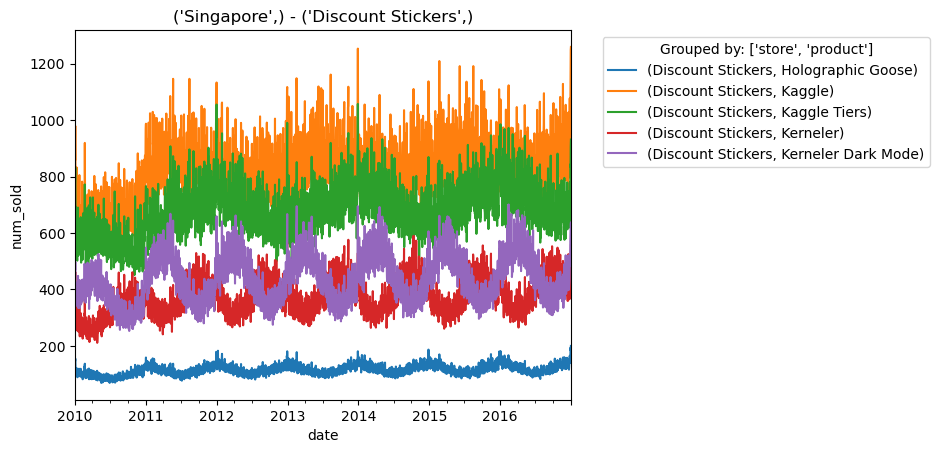

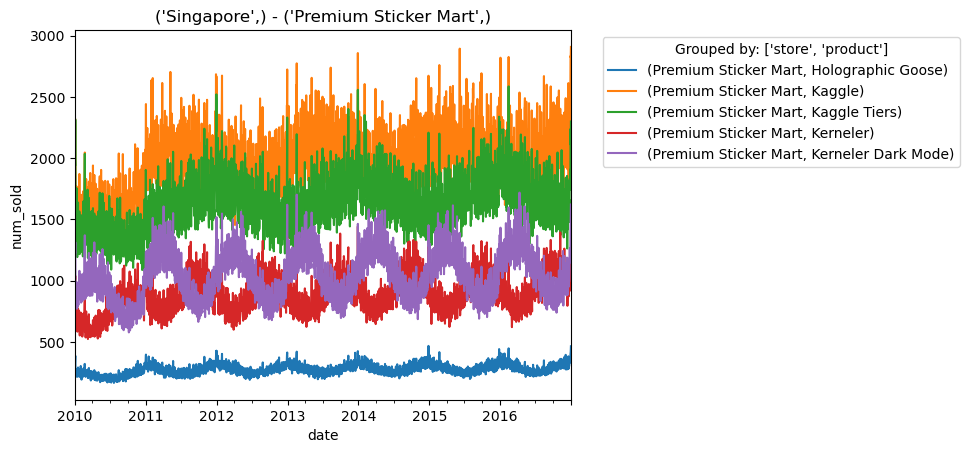

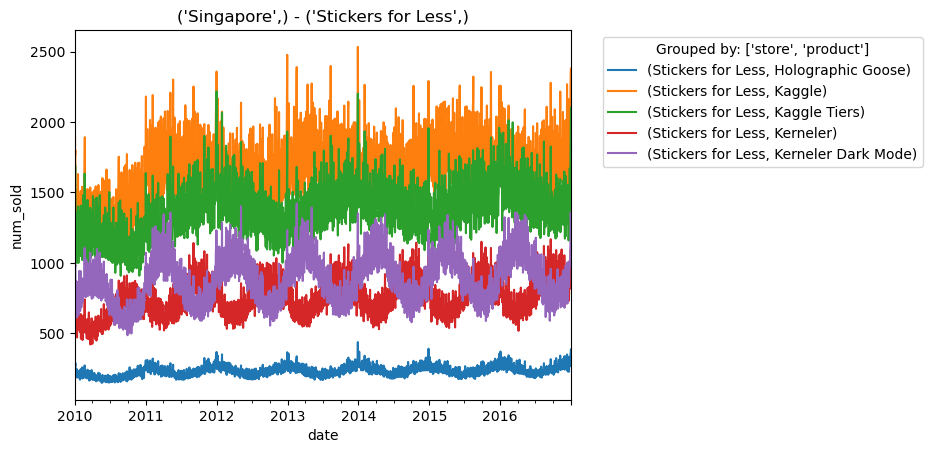

In [34]:
for country, country_df in train.groupby(['country']):
    for store, country_store_df in country_df.groupby(['store']):
        plot_grouped_time_series(country_store_df, title = f'{country} - {store}')

##### Group by product


1. The general seasonality pattern for all products: increase in `num_sold` from mid-year to year-end culminating at spike during holiday seasons, decrease from year-start to mid-year
2. The `num_sold` for the same `product` shows a similar seasonality pattern across different countries
3. Some products show stronger seasonality (Holographic Goose, Kerneler and dark mode) than others

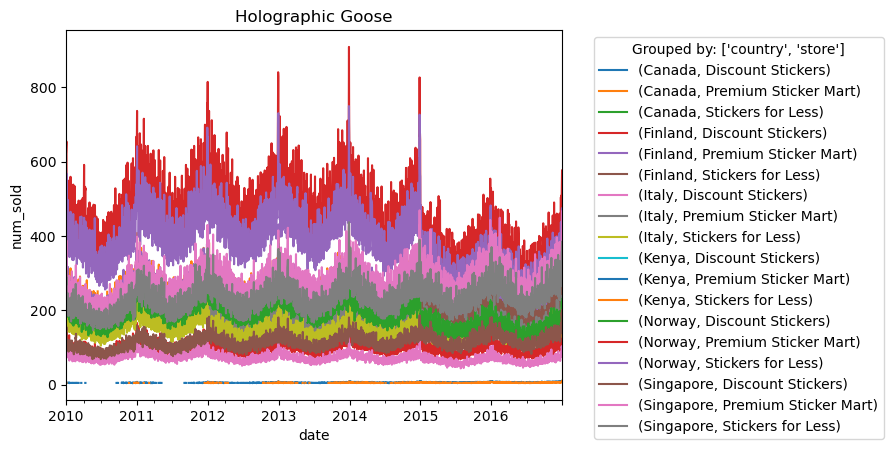

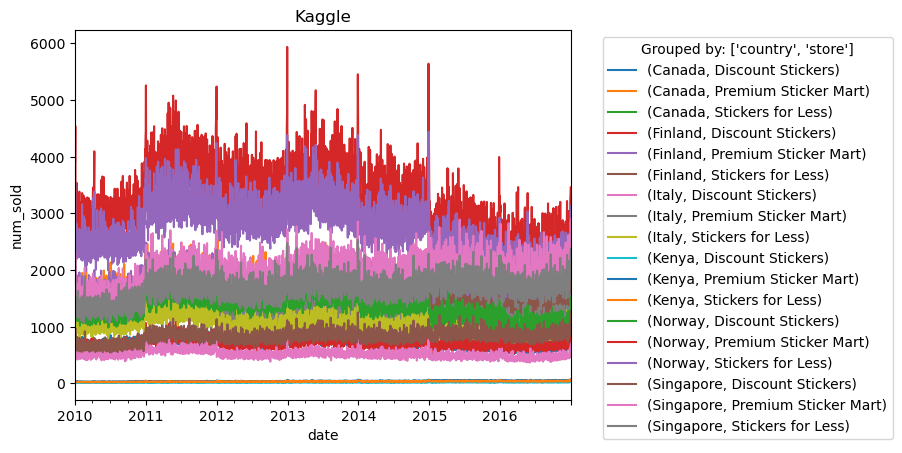

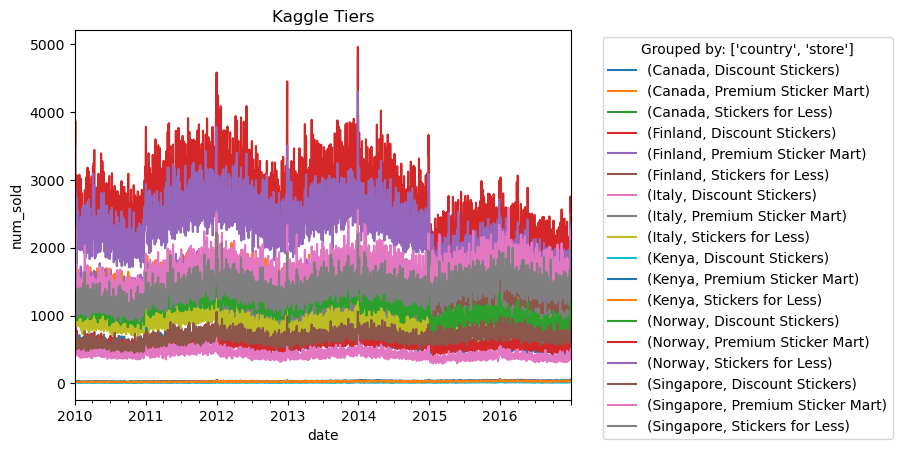

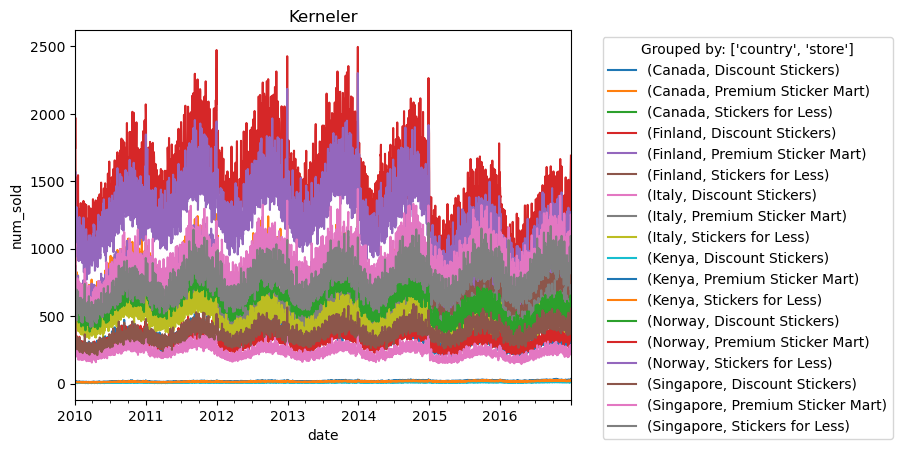

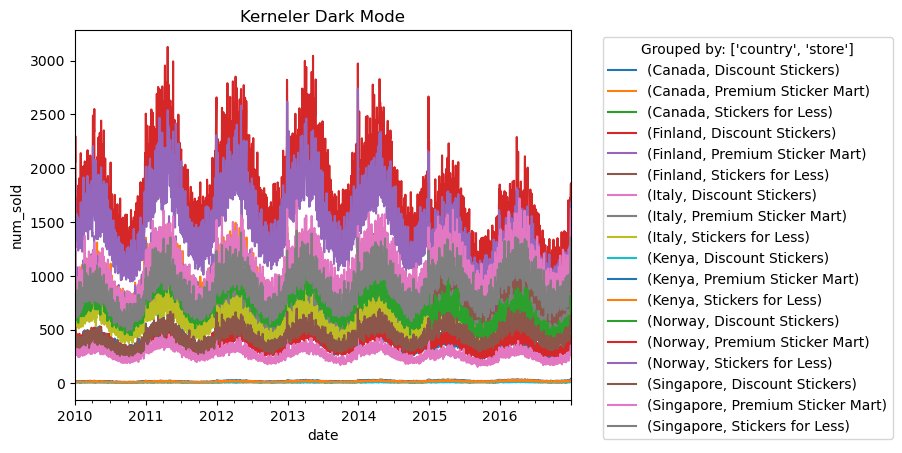

In [23]:
for product, product_df in train.groupby(['product']):
    plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

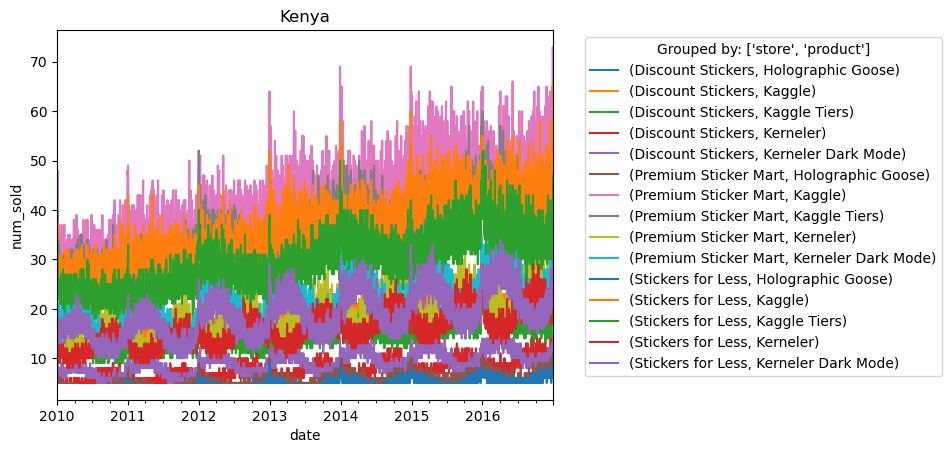

Zoom in a bit on Kenya sales. The general pattern still holds.

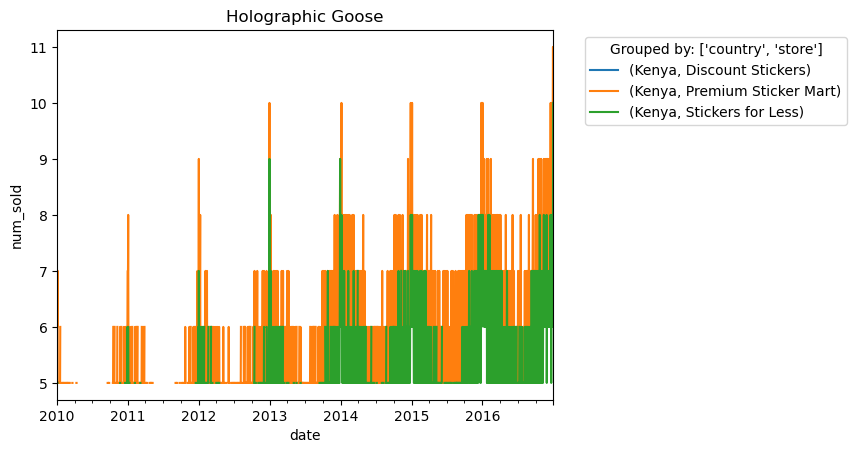

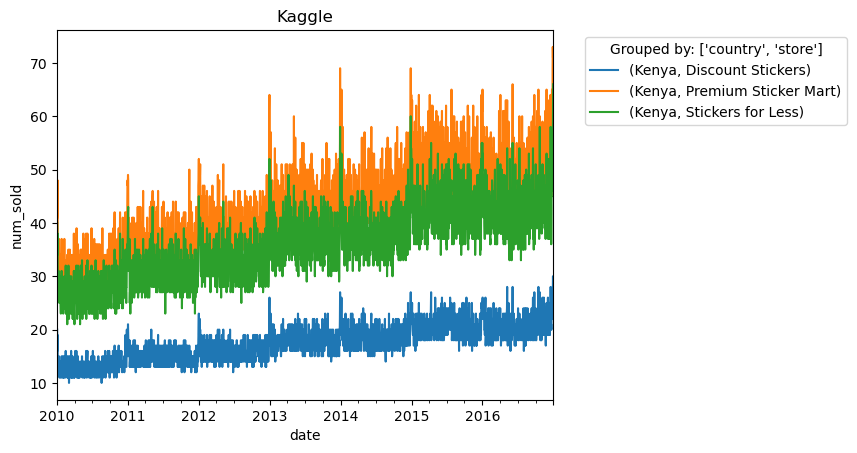

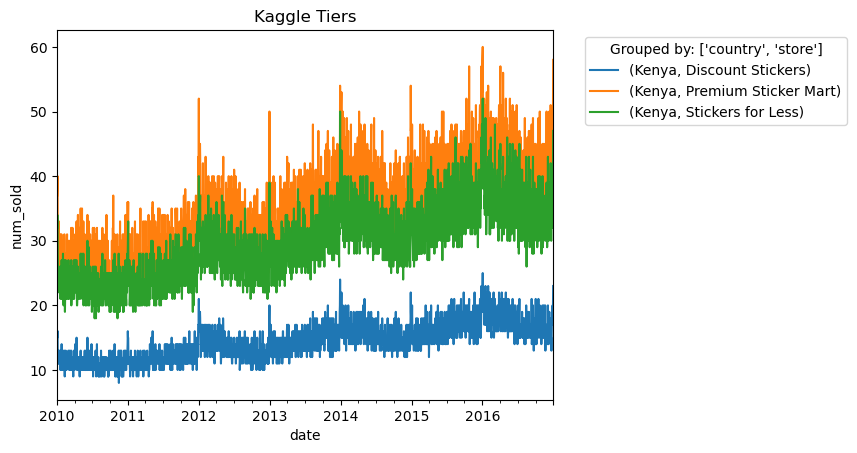

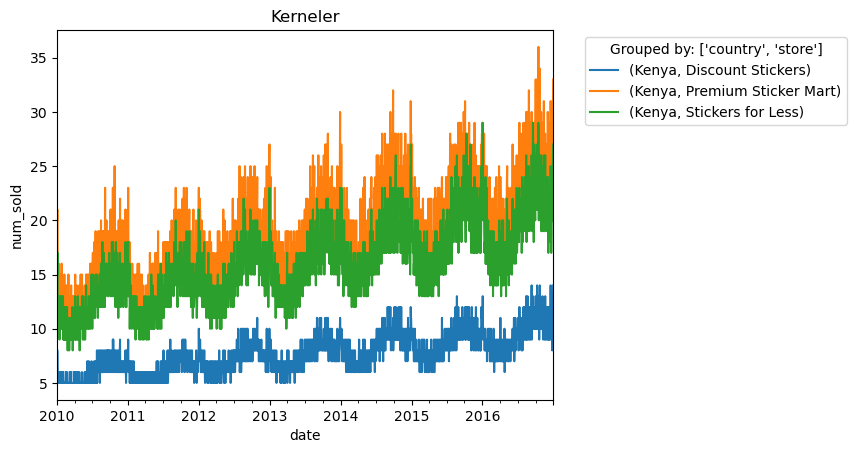

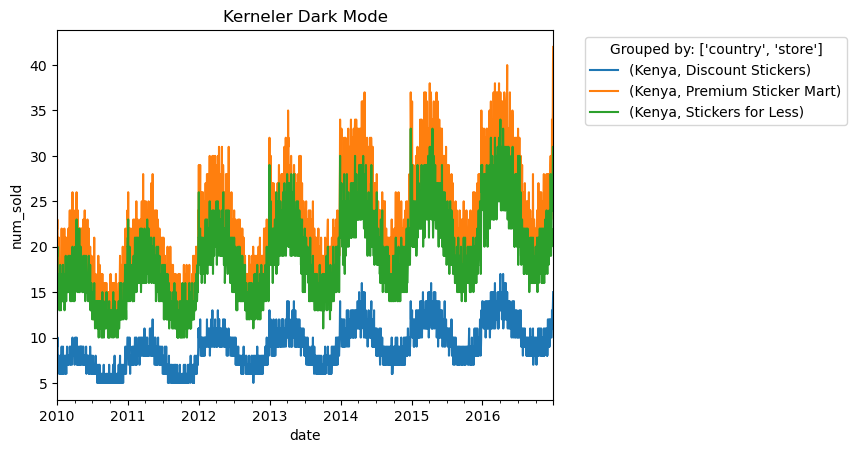

In [25]:
for product, product_df in train[train['country'] == 'Kenya'].groupby(['product']):
    plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

# Data Preprocessing

### Impute Missing Values

In [26]:
train[train['num_sold'].isnull()].groupby(['country', 'store', 'product']).count()

id  date  num_sold
country store                product                                 
Canada  Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler               1     1         0
        Premium Sticker Mart Holographic Goose    380   380         0
        Stickers for Less    Holographic Goose   1308  1308         0
Kenya   Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler              63    63         0
                             Kerneler Dark Mode     1     1         0
        Premium Sticker Mart Holographic Goose    646   646         0
        Stickers for Less    Holographic Goose   1358  1358         0

In [35]:
train[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Holographic Goose')]

,id,date,country,store,product,num_sold
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
95,95,2010-01-02,Canada,Stickers for Less,Holographic Goose,281.0
185,185,2010-01-03,Canada,Stickers for Less,Holographic Goose,297.0
275,275,2010-01-04,Canada,Stickers for Less,Holographic Goose,235.0
365,365,2010-01-05,Canada,Stickers for Less,Holographic Goose,240.0
...,...,...,...,...,...,...
229685,229685,2016-12-27,Canada,Stickers for Less,Holographic Goose,233.0
229775,229775,2016-12-28,Canada,Stickers for Less,Holographic Goose,261.0
229865,229865,2016-12-29,Canada,Stickers for Less,Holographic Goose,266.0
229955,229955,2016-12-30,Canada,Stickers for Less,Holographic Goose,303.0


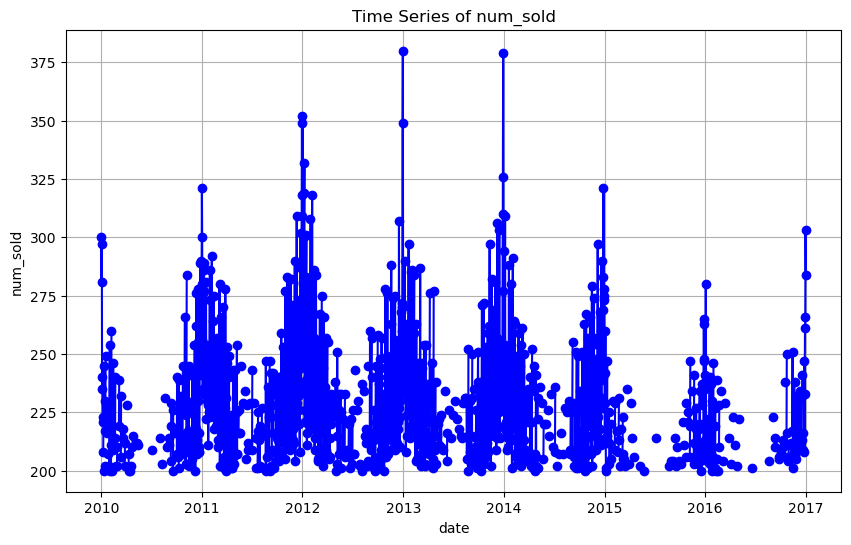

In [37]:
from statsmodels.tsa.seasonal import STL
plot_single_serie(train[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Holographic Goose')])

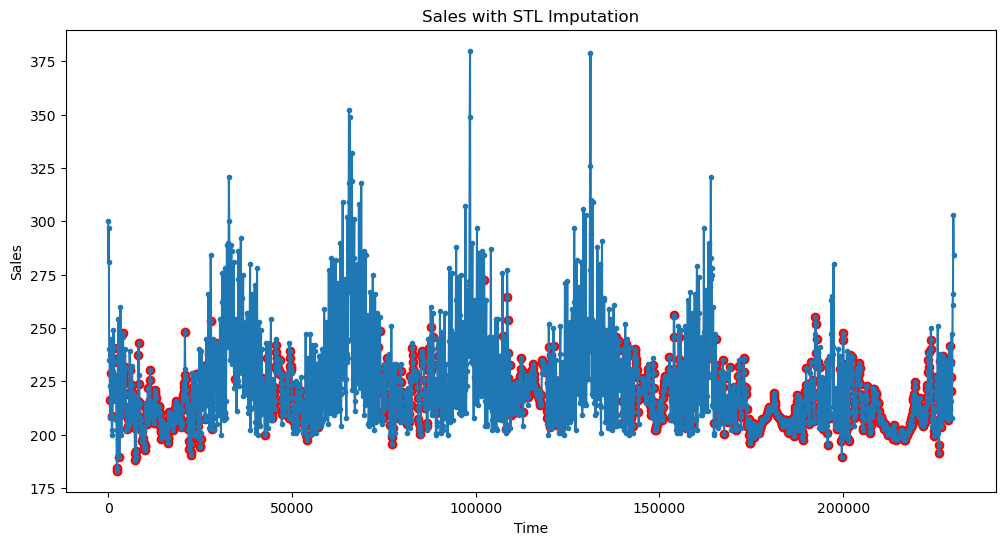

In [ ]:

df = train[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Holographic Goose')]

# Make a copy of the original dataframe
df_copy = df.copy()

# Fill missing values in the time series
imputed_indices = df[df['num_sold'].isnull()].index
# Apply STL decompostion
stl = STL(df_copy['num_sold'].interpolate(), period = 365)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['num_sold'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'num_sold'] = df_imputed[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['num_sold'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'num_sold'], color='red')

plt.title("Sales with STL Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()
